In [1]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [2]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [3]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e20.pth'

In [5]:
cfg.merge_from_file(fn_config)
# cfg.TRACK.LR = 0.1
cfg.TRACK.WINDOW_INFLUENCE = float(np.power(0.42, 1.0))

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [6]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001'
# fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [7]:
def _iou(lhs, rhs):
    lhs = np.transpose(np.reshape(lhs, (-1, 4)), (1, 0))
    rhs = np.transpose(np.reshape(rhs, (-1, 4)), (1, 0))
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return (I / (A - I)).ravel()

In [8]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
   
#     if ii > 10:
#         break;
    
    if iou < 0.1:
        print('Miss at frame {}'.format(ii))
        break

#     plt.imshow(t_img[:, :, ::-1])
#     rect = plt.Rectangle((rbb[0], rbb[1]),
#                          rbb[2],
#                          rbb[3], fill=False,
#                          edgecolor=[1, 0, 0], linewidth=3.5)
#     plt.gca().add_patch(rect)
    
#     gtbb = gt_seq[ii]
#     rect = plt.Rectangle((gtbb[0], gtbb[1]),
#                          gtbb[2],
#                          gtbb[3], fill=False,
#                          edgecolor=[0, 1, 0], linewidth=2.5)
#     plt.gca().add_patch(rect)
#     plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
#     plt.clf()

Tracking started, total 725 frames.


/home/hyunjoon/github/tracking-pytorch/pysot/tracker/siamcar_tracker.py:180: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((w + pad) * (h + pad))


ValueError: cannot convert float NaN to integer

<Figure size 864x864 with 0 Axes>

In [ ]:
rbb = res['bbox']
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

for pbb in res['pred_bbox']:
    rect = plt.Rectangle((pbb[0], pbb[1]),
                         pbb[2],
                         pbb[3], fill=False,
                         edgecolor=[0, 0, 1], linewidth=1.5)
    plt.gca().add_patch(rect)
    
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

midx = np.argmax(_iou(gt_bb, res['pred_bbox']))
bbb = res['pred_bbox'][midx]
rect = plt.Rectangle((bbb[0], bbb[1]),
                     bbb[2],
                     bbb[3], fill=False,
                     edgecolor=[1, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

In [ ]:
plt.imshow(res['ctr_rpn'].reshape((25, 25)))

In [20]:
np.max(res['ctr_rpn'])

0.48865595

In [21]:
res['pred_bbox']

array([[288.0244  , 232.8274  , 109.09147 ,  98.19655 ],
       [290.81476 , 234.25848 ,  97.76363 ,  95.82995 ],
       [286.23016 , 234.02573 , 106.89335 ,  93.44128 ],
       [285.34912 , 230.991   , 111.50602 , 105.488   ],
       [263.83704 , 235.04942 , 132.38289 , 101.50017 ],
       [218.79855 , 232.73207 , 141.51207 , 103.658356],
       [224.35483 , 233.53055 , 155.18301 , 102.42968 ],
       [266.14447 , 239.0166  , 129.47153 ,  93.67252 ],
       [276.63742 , 235.10052 , 115.13448 , 100.70378 ],
       [248.82114 , 232.0796  , 152.19058 , 104.31324 ],
       [291.73706 , 233.11484 , 104.29065 ,  91.39241 ],
       [257.93024 , 236.05797 , 135.9927  ,  92.215546],
       [218.58205 , 245.03212 , 170.58037 , 119.32303 ],
       [206.62714 , 234.38544 , 137.67659 , 100.880646],
       [281.63144 , 225.37177 , 112.21447 , 112.06605 ],
       [268.63754 , 234.95374 , 131.53246 ,  94.030304],
       [261.88168 , 243.46394 , 132.41096 , 103.38279 ],
       [217.08575 , 242.35759 ,

In [22]:
np.around(res['ctr_rcnn'], 3)

array([0.489, 0.39 , 0.351, 0.321, 0.305, 0.301, 0.264, 0.215, 0.202,
       0.197, 0.197, 0.194, 0.175, 0.166, 0.138, 0.128, 0.127, 0.12 ,
       0.11 , 0.103, 0.102, 0.093, 0.09 , 0.086, 0.077, 0.077, 0.069,
       0.061, 0.059, 0.058, 0.055, 0.05 ], dtype=float32)

In [23]:
np.around(res['cls_rcnn'], 3)

array([0.244, 0.662, 0.408, 0.533, 0.605, 0.059, 0.259, 0.627, 0.164,
       0.799, 0.454, 0.735, 0.226, 0.033, 0.45 , 0.649, 0.263, 0.269,
       0.48 , 0.216, 0.071, 0.012, 0.249, 0.238, 0.155, 0.132, 0.255,
       0.152, 0.222, 0.206, 0.03 , 0.177], dtype=float32)

In [24]:
np.around(res['pscore'], 3)

array([0.703, 0.646, 0.623, 0.606, 0.595, 0.54 , 0.542, 0.543, 0.537,
       0.529, 0.533, 0.528, 0.484, 0.429, 0.5  , 0.493, 0.488, 0.447,
       0.46 , 0.465, 0.478, 0.388, 0.467, 0.47 , 0.461, 0.455, 0.368,
       0.373, 0.403, 0.453, 0.365, 0.445], dtype=float32)

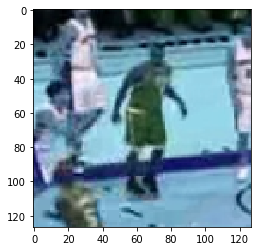

In [16]:
plt.imshow(tracker.img_z)

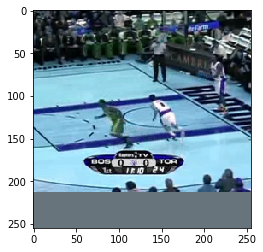

In [17]:
plt.imshow(tracker.img_x)

In [18]:
A = torch.zeros(3, 5)
B = torch.empty_like(A).normal_(0, 0.333)
C = torch.ones_like(A) * 2.0
C.pow_(B)

tensor([[1.4193, 1.1513, 0.8883, 1.5059, 0.6373],
        [0.9238, 0.7793, 0.6272, 0.9301, 1.3480],
        [1.0645, 1.0115, 1.0152, 1.4964, 1.0264]])

In [43]:
B

tensor([[-0.3523,  0.2594, -0.1564, -0.2552,  0.0228],
        [ 0.0039,  0.1023, -0.1720,  0.4048, -0.1212],
        [-0.2266, -0.1463, -0.7099, -0.3330, -0.7237]])